In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
import json
import numpy as np
import datetime
import dateutil
import pytz
from tqdm import tqdm
from joblib import Parallel,delayed

%matplotlib inline

In [2]:
BINANCE_ROOT_PATH = 'https://www.binance.com'
SPOT_API_PATH = 'api/v3'
FUTURE_API_PATH = 'fapi/v1'

def parse_datetime(dt):
    dt = dateutil.parser.parse(dt)
    if dt.tzinfo is None:
        dt = datetime.datetime(year=dt.year,month=dt.month,day=dt.day,hour=dt.hour,minute=dt.minute,second=dt.second, \
             microsecond=dt.microsecond,tzinfo=pytz.UTC)
    else:
        dt = dt.astimezone(pytz.UTC)
    return dt

In [3]:
def requests_instruments(API_PATH,status=None,baseAsset=None,quoteAsset=None):
    R = requests.get(
        url = os.path.join(BINANCE_ROOT_PATH,API_PATH,'exchangeInfo')
    )
    result = R.json()
    instruments = pd.DataFrame(
        [(item['symbol'],item['status'],item['baseAsset'],item['quoteAsset']) for item in result['symbols']],
       columns=['symbol','status','baseAsset','quoteAsset']
    )
    if status is not None:
        instruments = instruments[instruments['status']==status]
    if baseAsset is not None:
        instruments = instruments[instruments['baseAsset']==baseAsset]
    if quoteAsset is not None:
        instruments = instruments[instruments['quoteAsset']==quoteAsset]
    return instruments

In [4]:
def request_candles(API_PATH,symbol,interval,startTime,endTime,format_timestamp=False):
    # startTime, endTime - unix timesamp in milliseconds (Binance compatible value)\
    
    data = list()
    currStartTime = startTime
    while currStartTime < endTime:
        R = requests.get(
            url = os.path.join(BINANCE_ROOT_PATH,API_PATH,'klines'),
            params = {
                'symbol' : symbol,
                'interval' : interval,
                'limit' : 1000,
                'startTime' : currStartTime,
                'endTime' : endTime - 1,
            }
        )
        if not R.ok:
            raise Exception(R.text)
        else:
            curr_data = R.json()
            if not len(curr_data):
                break

            data += curr_data
            currStartTime = curr_data[-1][6] + 1 # update next iteration start time
            if currStartTime >= endTime:
                break
        
    candles = pd.DataFrame(
        data,
        columns=['openTimestamp', 'open', 'high', 'low', 'close', 'baseVolume', 'closeTimestamp', 'quoteVolume', 'numTrades', 'takerBuyBaseVolume', 'takerBuyQuoteVolume', 'unused']
    ).drop(['closeTimestamp','unused'],axis=1).astype({
        'open' : float,
        'high' : float,
        'low' : float,
        'close' : float,
        'baseVolume' : float,
        'quoteVolume' : float,
        'takerBuyBaseVolume' : float,
        'takerBuyQuoteVolume' : float
    }).set_index('openTimestamp') if len(data) else pd.DataFrame(
        columns=['open','high','low','close','baseVolume','quoteVolume','numTrades','takerBuyBaseVolume','takerBuyQuoteVolume'],
        index = pd.DatetimeIndex([],tz=pytz.utc,name='openTimestamp')
    ).astype({
        'open' : float,
        'high' : float,
        'low' : float,
        'close' : float,
        'baseVolume' : float,
        'quoteVolume' : float,
        'takerBuyBaseVolume' : float,
        'takerBuyQuoteVolume' : float
    })
    if candles.shape[0] and format_timestamp:
        candles.index = candles.index.map(lambda ts : datetime.datetime.fromtimestamp(ts/1000,tz=pytz.utc))
    return candles

Task 1

In [5]:
spot_symbols = requests_instruments(SPOT_API_PATH,status='TRADING',quoteAsset='USDT').symbol.tolist()
future_symbols = requests_instruments(FUTURE_API_PATH,status='TRADING',quoteAsset='USDT').symbol.tolist()

In [6]:
def trading_dec2020(API_PATH,symbols):
    
    result = Parallel(n_jobs=10)(
        delayed(request_candles)(API_PATH,symbol,'1M',int(1000*parse_datetime('2020-12-01').timestamp()), int(1000*parse_datetime('2021-01-01').timestamp()),True)
        for symbol in symbols)

    spd=[]
    for i in range(len(result)): 
        if (len(result[i].numTrades) != 0) and (result[i].numTrades[0]>0):
            spd.append (symbols[i])
    return spd

In [7]:
dec2020_spot_symbols = trading_dec2020(SPOT_API_PATH,spot_symbols)

In [8]:
dec2020_future_symbols = trading_dec2020(FUTURE_API_PATH,future_symbols)

In [9]:
my_symbols = np.intersect1d(dec2020_spot_symbols,dec2020_future_symbols)

In [10]:
len(my_symbols)

73

Task 2

In [11]:
spot_result = Parallel(n_jobs=10)(
    delayed(request_candles)(SPOT_API_PATH,symbol,'2h',int(1000*parse_datetime('2021-01-01').timestamp()),int(1000*parse_datetime('2022-01-01').timestamp()),True)
    for symbol in tqdm(my_symbols)
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:44<00:00,  1.63it/s]


In [12]:
future_result = Parallel(n_jobs=10)(
    delayed(request_candles)(FUTURE_API_PATH,symbol,'2h',int(1000*parse_datetime('2021-01-01').timestamp()),int(1000*parse_datetime('2022-01-01').timestamp()),True)
    for symbol in tqdm(my_symbols)
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:34<00:00,  2.11it/s]


Task 3

In [13]:
def mk_dict(dfs,symbols):
    r=dict()
    for i in dfs[0].columns.tolist():
        a=pd.DataFrame(dfs[0][i]).rename(columns={i: symbols[0]})
        for j in range(1,len(symbols)):
            b=dfs[j][i]
            a[symbols[j]] = b
        r[i] = a
    return r

In [14]:
spot_data = mk_dict(spot_result,my_symbols)

In [15]:
future_data = mk_dict(future_result,my_symbols)

In [16]:
spot_data

{'open':                            1INCHUSDT  AAVEUSDT  ADAUSDT  ALGOUSDT  ALPHAUSDT  \
 openTimestamp                                                                  
 2021-01-01 00:00:00+00:00     1.3623    88.350  0.18134    0.3358    0.18460   
 2021-01-01 02:00:00+00:00     1.2951    87.422  0.18361    0.3447    0.19134   
 2021-01-01 04:00:00+00:00     1.2590    88.441  0.18299    0.3591    0.18869   
 2021-01-01 06:00:00+00:00     1.2264    89.102  0.18299    0.3598    0.19027   
 2021-01-01 08:00:00+00:00     1.2343    86.644  0.17955    0.3573    0.18823   
 ...                              ...       ...      ...       ...        ...   
 2021-12-31 14:00:00+00:00     2.4730   270.200  1.35400    1.7498    0.69700   
 2021-12-31 16:00:00+00:00     2.4870   268.200  1.35500    1.7590    0.69900   
 2021-12-31 18:00:00+00:00     2.4140   259.700  1.32500    1.6938    0.68190   
 2021-12-31 20:00:00+00:00     2.3490   249.500  1.28600    1.6307    0.65470   
 2021-12-31 22:00:00

In [17]:
future_data

{'open':                            1INCHUSDT  AAVEUSDT  ADAUSDT  ALGOUSDT  ALPHAUSDT  \
 openTimestamp                                                                  
 2021-01-01 00:00:00+00:00     1.3658    88.581  0.18158    0.3363    0.18514   
 2021-01-01 02:00:00+00:00     1.2998    87.669  0.18388    0.3447    0.19187   
 2021-01-01 04:00:00+00:00     1.2619    88.588  0.18329    0.3594    0.18935   
 2021-01-01 06:00:00+00:00     1.2290    89.229  0.18329    0.3603    0.19034   
 2021-01-01 08:00:00+00:00     1.2381    86.730  0.17963    0.3579    0.18907   
 ...                              ...       ...      ...       ...        ...   
 2021-12-31 14:00:00+00:00     2.4710   270.310  1.35340    1.7505    0.69620   
 2021-12-31 16:00:00+00:00     2.4842   268.090  1.35460    1.7602    0.69850   
 2021-12-31 18:00:00+00:00     2.4137   259.710  1.32370    1.6944    0.68210   
 2021-12-31 20:00:00+00:00     2.3456   249.650  1.28420    1.6306    0.65540   
 2021-12-31 22:00:00

Task 4

,1INCHUSDT,AAVEUSDT,ADAUSDT,ALGOUSDT,ALPHAUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,BALUSDT,BANDUSDT,...,WAVESUSDT,XLMUSDT,XMRUSDT,XRPUSDT,XTZUSDT,YFIUSDT,ZECUSDT,ZENUSDT,ZILUSDT,ZRXUSDT
openTimestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,1.316871,87.319712,0.181398,0.342815,0.188363,6.366741,3.170558,0.533416,13.881882,5.445184,...,6.238069,0.131283,157.692227,0.222213,2.011411,22715.237103,64.791358,11.648652,0.086350,0.356253
2021-01-01 02:00:00+00:00,1.269301,87.777093,0.183870,0.353468,0.190771,6.311949,3.085456,0.535837,14.143202,5.552124,...,6.215360,0.132015,160.837878,0.225247,2.068885,23217.350339,65.611848,12.425325,0.086067,0.360518
2021-01-01 04:00:00+00:00,1.234117,88.336534,0.182557,0.358920,0.189480,6.108595,3.096187,0.539628,14.104877,5.569599,...,6.143410,0.133762,159.773327,0.240294,2.049041,22928.342563,65.297576,12.492771,0.086550,0.359829
2021-01-01 06:00:00+00:00,1.232573,87.306308,0.179902,0.359079,0.187596,5.973808,3.102786,0.525278,14.001886,5.558619,...,6.187536,0.132104,159.245029,0.231621,2.023291,22280.890789,64.871184,12.858904,0.084854,0.356903
2021-01-01 08:00:00+00:00,1.181376,85.767886,0.178220,0.360267,0.184988,5.976727,3.176058,0.517908,13.938195,5.512866,...,6.101676,0.131093,159.711773,0.231012,2.013184,22028.797429,64.432279,12.647888,0.085661,0.353920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 14:00:00+00:00,2.482682,269.117662,1.353933,1.755616,0.699015,31.515866,107.129010,96.924721,17.561983,5.183314,...,14.916012,0.274358,231.676960,0.840707,4.442082,31984.340289,153.575684,64.073554,0.079117,0.827311
2021-12-31 16:00:00+00:00,2.440319,262.330761,1.335650,1.714550,0.686104,32.384822,107.100851,94.483165,17.662934,5.138661,...,14.768655,0.271627,232.614694,0.835078,4.389211,32454.607274,151.862744,62.924992,0.077900,0.826530
2021-12-31 18:00:00+00:00,2.384007,254.450458,1.304463,1.665152,0.666724,31.845704,105.894264,92.576911,17.445236,5.008154,...,14.596653,0.264328,231.459023,0.817501,4.284095,32617.475371,147.235866,61.382989,0.075366,0.792201


In [30]:
spot_data['vwap'] = spot_data['quoteVolume'] / spot_data['baseVolume']

In [31]:
future_data['vwap'] = future_data['quoteVolume'] / future_data['baseVolume']

Task 5

In [32]:
alpha_spot = spot_data['vwap'] / spot_data['close'] -1
alpha_future = future_data['vwap'] / future_data['close'] -1

In [33]:
alpha_future = alpha_future.sub(alpha_future.mean(axis=1),axis=0)
alpha_future = alpha_future.div(alpha_future.abs().sum(axis=1), axis=0)
for _ in range(5):
    alpha_future = alpha_future.clip(-0.05,0.05)
    alpha_future = alpha_future.sub(alpha_future.mean(axis=1),axis=0)
    alpha_future = alpha_future.div(alpha_future.abs().sum(axis=1),axis=0)

alpha_spot = alpha_spot.sub(alpha_spot.mean(axis=1),axis=0)
alpha_spot = alpha_spot.div(alpha_spot.abs().sum(axis=1), axis=0)
for _ in range(5):
    alpha_spot = alpha_spot.clip(-0.05,0.05)
    alpha_spot = alpha_spot.sub(alpha_spot.mean(axis=1),axis=0)
    alpha_spot = alpha_spot.div(alpha_spot.abs().sum(axis=1),axis=0)

Task 6

In [35]:
spot_pnl = (alpha_spot.shift() * (spot_data['close']/spot_data['close'].shift()-1)).sum(axis=1)

# & incorrect formula for pnl

In [36]:
future_pnl = (alpha_future.shift() * (future_data['close']/future_data['close'].shift()-1)).sum(axis=1)

In [44]:
daily_spot_pnl = spot_pnl.resample('1d').sum()

Sharpe 10.50517659783823
Turnover 1.4422031702313398


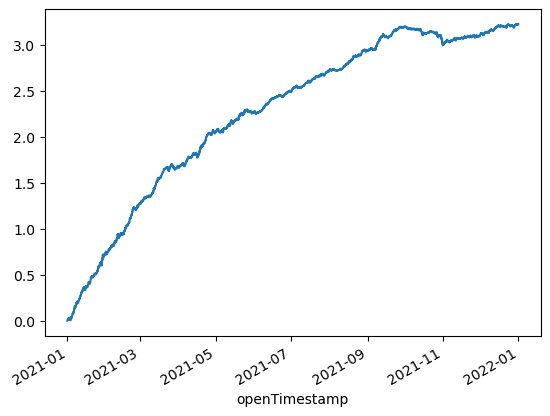

In [46]:
spot_pnl.cumsum().plot()
print ('Sharpe', np.sqrt(12*365) * spot_pnl.mean() / spot_pnl.std())
print ('Turnover', (alpha_spot - alpha_spot.shift()).abs().sum(axis=1).mean(axis=0))

Sharpe 7.412157101783611
Turnover 1.4352674756412913


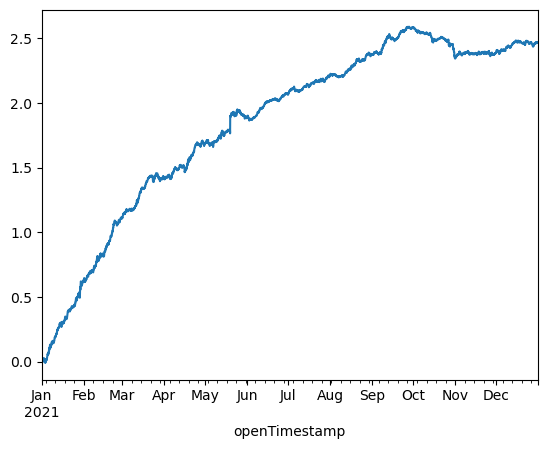

In [47]:
future_pnl.cumsum().plot()
print ('Sharpe', np.sqrt(12*365) * future_pnl.mean() / future_pnl.std())
print ('Turnover', (alpha_future - alpha_future.shift()).abs().sum(axis=1).mean(axis=0))

Нереальные значения, т.к. все считается с интервалом 2ч., а альфу на самом деле нужно считать раз в сутки.

Task 4 Daily

In [228]:
spot_data['vwap1'] = spot_data['close'] * spot_data['baseVolume']
spot_data['vwap1'] = spot_data['vwap1'].resample(rule='1d', label = 'right').sum() / \
                    spot_data['baseVolume'].resample(rule='1d', label = 'right').sum()

In [230]:
future_data['vwap1'] = future_data['close'] * future_data['baseVolume']
future_data['vwap1'] = future_data['vwap1'].resample(rule='1d', label = 'right').sum() / \
                    future_data['baseVolume'].resample(rule='1d', label = 'right').sum()

Task 5 Daily

In [247]:
alpha_spot_daily = spot_data['vwap1'] / spot_data['close'].resample(rule='1d', label = 'right').last() - 1

In [248]:
alpha_future_daily = future_data['vwap1'] / future_data['close'].resample(rule='1d', label = 'right').last() - 1

In [249]:
alpha_future_daily = alpha_future_daily.sub(alpha_future_daily.mean(axis=1),axis=0)
alpha_future_daily = alpha_future_daily.div(alpha_future_daily.abs().sum(axis=1), axis=0)
for _ in range(5):
    alpha_future_daily = alpha_future_daily.clip(-0.05,0.05)
    alpha_future_daily = alpha_future_daily.sub(alpha_future_daily.mean(axis=1),axis=0)
    alpha_future_daily = alpha_future_daily.div(alpha_future_daily.abs().sum(axis=1),axis=0)

alpha_spot_daily = alpha_spot_daily.sub(alpha_spot_daily.mean(axis=1),axis=0)
alpha_spot_daily = alpha_spot_daily.div(alpha_spot_daily.abs().sum(axis=1), axis=0)
for _ in range(5):
    alpha_spot_daily = alpha_spot_daily.clip(-0.05,0.05)
    alpha_spot_daily = alpha_spot_daily.sub(alpha_spot_daily.mean(axis=1),axis=0)
    alpha_spot_daily = alpha_spot_daily.div(alpha_spot_daily.abs().sum(axis=1),axis=0)

Task 6 Daily

In [250]:
spot_d_close = spot_data['close'].resample(rule='1d', label = 'right').last()
future_d_close = future_data['close'].resample(rule='1d', label = 'right').last()

In [251]:
spot_d_pnl = (alpha_spot_daily.shift() * (spot_d_close-spot_d_close.shift())).sum(axis=1)

In [252]:
future_d_pnl = (alpha_future_daily.shift() * (future_d_close-future_d_close.shift())).sum(axis=1)

<AxesSubplot:xlabel='openTimestamp'>

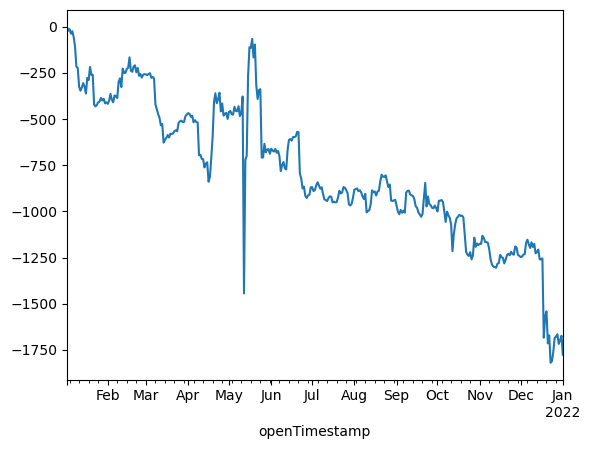

In [253]:
spot_d_pnl.cumsum().plot()

<AxesSubplot:xlabel='openTimestamp'>

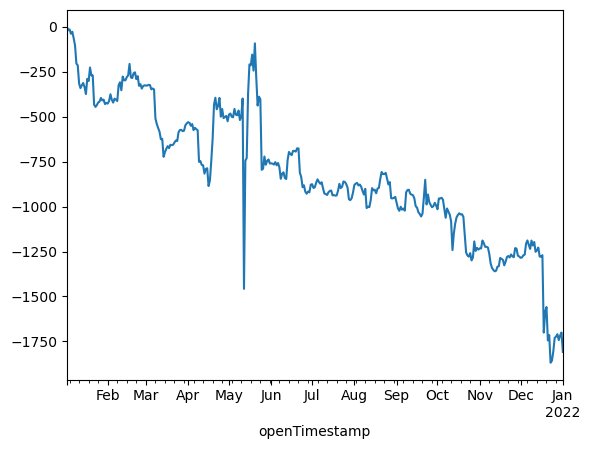

In [254]:
future_d_pnl.cumsum().plot()

Не лучше